# Introduccion

En este ejercicio número 1 del Trabajo Práctico de la materia Sistemas Operativos Avanzados, vamos a utilizar el algoritmo *Mean Filter* sobre una imagen, y luego se mostrará el resultado.

Mean Filter es un algoritmo de procesamiento de imágenes del tipo "sliding-window", que reemplaza valores (píxeles) de la imagen con un valor promedio (*mean*) de los valores que lo rodean.

Por ejemplo, utilizando una ventana de tamaño 3x3, con los valores siguientes:

|   |   |   |
|:-:|:-:|:-:|
| 5 | 3 | 6 |
| 2 | 1 | 9 |
| 8 | 4 | 7 |

Tenemos que el valor promedio es

$$
sum = 5 + 3 + 6 + 2 + 1 + 9 + 8 + 4 + 7 = 45\\
avg = 45 / 9 = 5
$$

Y entonces, nuestra ventana 3x3 quedara de la siguiente manera:

|   |   |   |
|:-:|:-:|:-:|
| 5 | 3 | 6 |
| 2 | 5 | 9 |
| 8 | 4 | 7 |

Este procesamiento se realiza por cada ventana posible de la imagen, por lo tanto, para una imagen de tamaño n, con un tamaño de ventana m, el algoritmo por CPU tendrá una complejidad computacional de $O(n^2 \cdot m^2)$ donde $m \ll n$.

Tamaños comunes de ventana serán $5\times5$ o $3\times3$.


# Armado del ambiente

Principalmente, vamos a necesitar dos cosas:

- `pycuda`.
- Una imagen.

In [2]:
!pip -q install pycuda

     |████████████████████████████████| 1.7 MB 12.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 66 kB 4.4 MB/s 
     |████████████████████████████████| 75 kB 4.3 MB/s 


In [3]:
img_url = "https://www.forbesindia.com/fbimages/900x600/proportional/jpeg/media/images/2011/Nov/topimg_17442_bwk_frank.jpg"
if img_url == "":
  raise Exception("Debe ingresar la url de la imagen")

!wget {img_url} -O img --no-verbose

2021-12-01 21:01:18 URL:https://www.forbesindia.com/fbimages/900x600/proportional/jpeg/media/images/2011/Nov/topimg_17442_bwk_frank.jpg [73076] -> "img" [1]


## Funciones utilitarias

Definimos unas funciones utilitarias que vamos a utilizar tanto en CPU como en GPU.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math
import time

# El path hacia la imagen que se descargo en el paso anterior.
img_name = 'img'

# Si se quiere que se detalle paso a paso lo que se hace.
verbose = True

# Constantes del tamaño de la ventana a usar
window_side = 3
window_sz = window_side * window_side
half_window = window_side//2

# Constantes para la cantidad de hilos para GPU
dim_thread_x = 32
dim_thread_y = 32

if dim_thread_x * dim_thread_y > 1024:
  raise Exception("La cantidad de hilos de un bloque debe ser menor a 1024")

def read_image(path):
  """
  Lee una imagen para determinado path. 
  Devuelve un arreglo tridimensional, su altura y su ancho
  """
  img = Image.open(path)
  width, height = img.size
  return np.asarray(img).astype(np.int32()), width, height

def show_image(img, title, subplot):
  """ Muestra una imagen usando matplotlib """
  plt.subplot(subplot)
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.title(title)


def show_images(original, filtered):
  """
  Muestra las dos imagenes, la original y la filtrada, ambas dentro del mismo 
  grafico.

  Params:
  original -- un array tridimensional que representa la imagen original.
  filtered -- un array tridimensional que representa la imagen filtrada.
  """
  plt.gcf().set_size_inches(25, 25)
  show_image(original, 'Original', 131)
  show_image(filtered, 'Mean Filter', 132)
  plt.show()

def do_image_processing(func, proc):
  """
  Realiza el procesamiento de la imagen. 
  func es la funcion a utilizar puede ser la de cpu o la de gpu.
  proc es el nombre del procesador. GPU o CPU.
  """
  # Leo la imagen
  # La imagen es un arreglo tridimensional.
  img, w, h = read_image(img_name)

  if verbose:
    print('Imagen ' + img_name + ' leida')
    print('Altura: ', h)
    print('Ancho: ', w)
    print('')

  # En este arreglo voy a guardar la imagen ya filtrada.
  filtered = img.copy()

  if verbose:
    print(f'Comienza el procesamiento de la imagen ({proc})')
    print('Con un tamaño de ventana de {:d}x{:d}'.format(window_side, window_side))
    print('')

  start = time.perf_counter()
  filtered = func(img, filtered, w, h)
  end = time.perf_counter()

  if verbose:
    print('Fin de procesamiento de la imagen. Procedemos a mostrar.')

  # Una vez finalizado el procesamiento de la imagen, la muestro.
  show_images(img, filtered)
  print('Se ha completado la ejecucion en {:f} segundos'.format(end - start))

# Desarrollo CPU

Imagen img leida
Altura:  600
Ancho:  900

Comienza el procesamiento de la imagen (CPU)
Con un tamaño de ventana de 3x3

[169 200 156]
[168 197 154]
Fin de procesamiento de la imagen. Procedemos a mostrar.


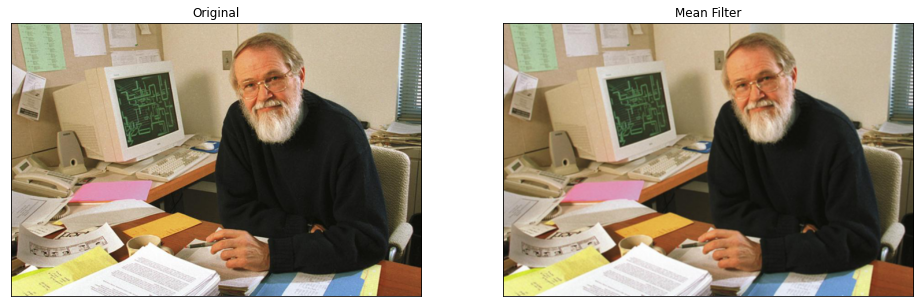

Se ha completado la ejecucion en 18.133406 segundos


In [10]:
def mean_filter(img, i, j, half, window_size, w, h):
  """
  Obtiene el valor promedio de la ventana para R, G, y B.

  Params:
  img -- un array tridimensional que representa la imagen original. No 
  se modifica.
  i -- indice horizontal.
  j -- indice vertical.
  half_window -- tamaño de media ventana. Util para realizar el desplazamiento.
  por ejemplo, para una ventana de tamaño 25 (5x5), el desplazamiento es de 2 
  (5//2). Y para una ventana de tamaño 9 (3x3), el desplazamiento es de 1 (3//2).
  window_size -- tamaño de la ventana. Por ejemplo, para una ventana 5x5, su 
  tamaño es 25.

  Return: el promedio para R, G, y B.
  """
  
  r, g, b = 0, 0, 0
  top    = j-half if j-half>=0 else 0
  bottom = j+half if j+half<=h-1 else h-1
  left   = i-half if i-half>=0 else 0
  right  = i+half if i+half<=w-1 else w-1
  for x in range(left, right+1):
    for y in range(top, bottom+1):
      r, g, b = r+img[y][x][0], g+img[y][x][1], b+img[y][x][2]

  return r//window_size, g//window_size, b//window_size

def cpu_mean_filter(img, filtered, w, h):
  for i in range(0, w-1):
    for j in range(0, h-1):
      r, g, b = mean_filter(img, i, j, half_window, window_sz, w, h)
      filtered[j][i][0] = r
      filtered[j][i][1] = g
      filtered[j][i][2] = b
    
  return filtered

do_image_processing(cpu_mean_filter, 'CPU')

# Desarrollo GPU

Imagen img leida
Altura:  600
Ancho:  900

Comienza el procesamiento de la imagen (GPU)
Con un tamaño de ventana de 3x3

Fin de procesamiento de la imagen. Procedemos a mostrar.


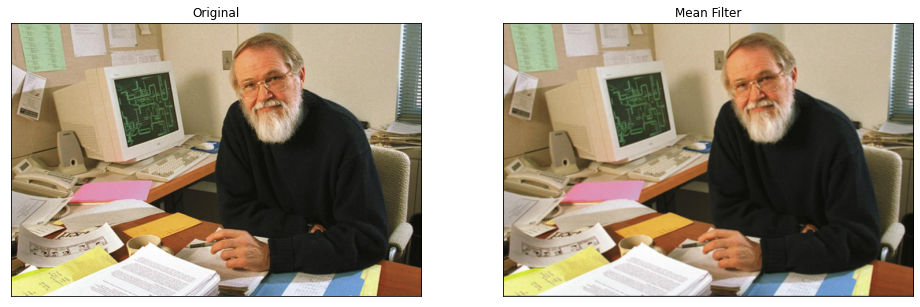

Se ha completado la ejecucion en 0.009804 segundos


In [11]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np

gpu_verbose = False

def gpu_mean_filter(img, filtered, w, h):
  # Pido memoria y copio los arreglos.
  try:
    gpu_img = cuda.mem_alloc(img.nbytes)
    gpu_filtered = cuda.mem_alloc(img.nbytes)
  except:
    print('Hubo un error al asignar memoria en GPU')

  try:
    cuda.memcpy_htod(gpu_img, img)
    cuda.memcpy_htod(gpu_filtered, filtered)
  except:
    print('Hubo un error al pasar la imagen a la GPU')

  src = SourceModule("""
  __global__ void kernel_img(
    const int w,
    const int h,
    const int half,
    const int sz,
    const int *img,
    int *filtered
  ) {
    const int i = blockIdx.x * blockDim.x + threadIdx.x;
    const int j = blockIdx.y * blockDim.y + threadIdx.y;

    if (i < w && j < h ){
      int r = 0, g = 0, b = 0;
        
      // move inside the window 
      const int top    = j-half>=0   ? j-half : 0;
      const int bottom = j+half<=h-1 ? j+half : h-1;
      const int left   = i-half>=0   ? i-half : 0;
      const int right  = i+half<=w-1 ? i+half : w-1;
      for(int x = left; x <= right; x++) {
            for(int y = top; y <= bottom; y++) {
                int pos = 3*(x+y*w); // three bytes
                r  += img[pos];
                g  += img[pos+1];
                b  += img[pos+2];
            }
      }

      const int k   = 3*(i+j*w);
      filtered[k]   = r/sz;
      filtered[k+1] = g/sz;
      filtered[k+2] = b/sz;
    }
  }
  """)
  dim_bloq_x = (w+dim_thread_x-1) // dim_thread_x
  dim_bloq_y = (h+dim_thread_y-1) // dim_thread_y

  if gpu_verbose:
    print(f'Dimension Bloques: ({dim_thread_x}, {dim_thread_y}, 1)')
    print(f'Dimension Grid: ({dim_bloq_x}, {dim_bloq_y}, 1)')
    print('')

  try:
    kernel = src.get_function("kernel_img")
  except:
    print('Hubo un error al obtener el kernel a enviar a la GPU.')

  try:
    kernel(\
          np.int32(w),\
          np.int32(h),\
          np.int32(half_window),\
          np.int32(window_sz),\
          gpu_img,\
          gpu_filtered,\
          block=(dim_thread_x, dim_thread_y, 1),\
          grid=(dim_bloq_x, dim_bloq_y, 1))
  except:
    print('Hubo un error al ejecutar el kernel en la GPU.')
  
  try:
    cuda.memcpy_dtoh(filtered, gpu_filtered)
  except:
    print('Hubo un error al obtener la imagen filtrada desde la GPU.')

  return filtered

do_image_processing(gpu_mean_filter, 'GPU')

# Métricas

Para obtener métricas útiles, vamos a ejecutar 15 veces el algoritmo para CPU y otras 15 veces para GPU. En base a esto, obtendremos un promedio.

In [ ]:
from IPython.display import display, Markdown
import timeit

img, w, h = read_image(img_name)
filtered = img.copy()
repetitions = 15

def cpu():
  cpu_mean_filter(img, filtered, w, h)

def gpu():
  gpu_mean_filter(img, filtered, w, h)

# Metricas de CPU
cpu_time = timeit.Timer(cpu).repeat(repeat=repetitions, number=1)

cpu_table = '|Iteración|Tiempo CPU|\n|-:|:-|\n'
avg = 0
for i, time in enumerate(cpu_time):
  cpu_table += '|{:d}|{:f} segundos|\n'.format(i+1, time)
  avg += time

avg /= len(cpu_time)
cpu_table += '|**Promedio CPU**| {:f} segundos|\n'.format(avg)
display(Markdown(cpu_table))


# Metricas de GPU
gpu_time = timeit.Timer(gpu).repeat(repeat=repetitions, number=1)

gpu_table = '|Iteración|Tiempo GPU|\n|-:|:-|\n'
avg = 0
for i, time in enumerate(gpu_time):
  gpu_table += '|{:d}|{:f} segundos|\n'.format(i+1, time)
  avg += time

avg /= len(gpu_time)
gpu_table += '|**Promedio GPU**| {:f} segundos|\n'.format(avg)
display(Markdown(gpu_table))

|Iteración|Tiempo CPU|
|-:|:-|
|1|11.212225 segundos|
|2|11.093988 segundos|
|3|11.134686 segundos|
|4|11.054931 segundos|
|5|11.319563 segundos|
|6|11.087412 segundos|
|7|11.014435 segundos|
|8|11.157982 segundos|
|9|11.091055 segundos|
|10|10.994878 segundos|
|11|11.059581 segundos|
|12|11.009011 segundos|
|13|10.898995 segundos|
|14|10.937704 segundos|
|15|10.942614 segundos|
|**Promedio CPU**| 11.067271 segundos|


|Iteración|Tiempo GPU|
|-:|:-|
|1|0.010603 segundos|
|2|0.006639 segundos|
|3|0.006478 segundos|
|4|0.006592 segundos|
|5|0.006520 segundos|
|6|0.006668 segundos|
|7|0.006285 segundos|
|8|0.006575 segundos|
|9|0.006551 segundos|
|10|0.007313 segundos|
|11|0.007776 segundos|
|12|0.006701 segundos|
|13|0.006480 segundos|
|14|0.006126 segundos|
|15|0.006707 segundos|
|**Promedio GPU**| 0.006934 segundos|


# Conclusiones

De las métricas obtenidas en la sección anterior, podemos llegar a la conclusión de que el procesamiento de la imagen utilizando GPU es 1730 veces más rápido que utilizando CPU. Esto se debe a que la primera aprovecha el paralelismo que entregan sus múltiples hilos de ejecución, mientras que la última realiza una tarea secuencial.

# Bibliografía

1. What are the Mean and Median filters? [Online]. Available: https://www.markschulze.net/java/meanmed.html. [Accessed: 22-Nov-2021].
2. CUDA Toolkit Documentation. [Online]. Available: https://docs.nvidia.com/cuda/. [Accessed: 22-Nov-2021].
3. A. Rukshan, “CUDA Mean Filter,” GitHub, 25-Jun-2019. [Online]. Available: https://github.com/Amila-Rukshan/CUDA-Mean-Filter/blob/master/meanFilter.cu. [Accessed: 22-Nov-2021].
